In [15]:
!pip install tensorflow_addons


In [16]:
import numpy as np 
import pandas as pd 
from PIL import Image 
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.applications import ResNet50

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_DIM = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 8

TRAIN_POSITIVE_SIZE = 460
TRAIN_NEGATIVE_SIZE = 4684
VALIDATION_POSITIVE_SIZE = 58
VALIDATION_NEGATIVE_SIZE = 562
TEST_POSITIVE_SIZE = 58
TEST_NEGATIVE_SIZE = 610

IMG_DIR = '/content/drive/MyDrive/summer 2021/sra/research/data/'
TRAIN_DIR = '/content/drive/MyDrive/summer 2021/sra/research/data/train'
VAL_DIR = '/content/drive/MyDrive/summer 2021/sra/research/data/validation'
TEST_DIR = '/content/drive/MyDrive/summer 2021/sra/research/data/test'

In [19]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                              horizontal_flip = True,
                                              width_shift_range = 0.2,
                                              height_shift_range = 0.2
                                            )
            
data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input)

In [20]:
train_generator = data_generator_with_aug.flow_from_directory(
                                        directory=TRAIN_DIR,
                                        target_size=IMG_DIM,
                                        batch_size=BATCH_SIZE,
                                        class_mode='categorical'
                                        )

validation_generator = data_generator_no_aug.flow_from_directory(
                                        directory=VAL_DIR,
                                        target_size=IMG_DIM,batch_size=BATCH_SIZE,
                                        class_mode='categorical')

test_generator = data_generator_no_aug.flow_from_directory(
                                        directory=TEST_DIR,
                                        target_size=IMG_DIM,batch_size=BATCH_SIZE,
                                        class_mode='categorical',
                                        )

print(train_generator.class_indices)
print(validation_generator.class_indices)
print(test_generator.class_indices)

Found 5144 images belonging to 3 classes.
Found 620 images belonging to 3 classes.
Found 668 images belonging to 3 classes.
{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}
{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}
{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}


In [21]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
import tensorflow.keras as keras

resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT,IMG_WIDTH,3),pooling='max')

output = resnet.layers[-1].output
output = tf.keras.layers.Flatten()(output)
resnet = Model(resnet.input, output)

res_name = []
for layer in resnet.layers:
    res_name.append(layer.name)

In [22]:
res_name[-22:]

['conv5_block2_1_conv',
 'conv5_block2_1_bn',
 'conv5_block2_1_relu',
 'conv5_block2_2_conv',
 'conv5_block2_2_bn',
 'conv5_block2_2_relu',
 'conv5_block2_3_conv',
 'conv5_block2_3_bn',
 'conv5_block2_add',
 'conv5_block2_out',
 'conv5_block3_1_conv',
 'conv5_block3_1_bn',
 'conv5_block3_1_relu',
 'conv5_block3_2_conv',
 'conv5_block3_2_bn',
 'conv5_block3_2_relu',
 'conv5_block3_3_conv',
 'conv5_block3_3_bn',
 'conv5_block3_add',
 'conv5_block3_out',
 'max_pool',
 'flatten_1']

In [23]:
set_trainable = False
for layer in resnet.layers:
    if layer.name in res_name[-22:]:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [24]:
resnet.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [25]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout

num_classes = 3

model = Sequential()
model.add(resnet)
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 2048)              23587712  
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 3075      
Total params: 26,738,563
Trainable params: 12,082,179
Non-trainable params: 14,656,384
_________________________________

In [26]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8,
                                              restore_best_weights=False
                                              )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                factor=0.2,
                                                patience=4,
                                                verbose=1,
                                                min_delta=5*1e-3,min_lr = 5*1e-7,
                                                )

In [27]:
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics=['accuracy',tfa.metrics.F1Score(num_classes=num_classes)])

In [28]:
model.fit(
          train_generator,     
          epochs = 12,
          callbacks=[early_stop,reduce_lr],
          validation_data = validation_generator
          )

Epoch 1/12
643/643 [==============================] - ETA: 0s - loss: 1.2056 - accuracy: 0.8427 - f1_score: 0.7906

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


643/643 [==============================] - 1577s 2s/step - loss: 1.2056 - accuracy: 0.8427 - f1_score: 0.7906 - val_loss: 0.3680 - val_accuracy: 0.9161 - val_f1_score: 0.9271
Epoch 2/12
643/643 [==============================] - 195s 304ms/step - loss: 0.3856 - accuracy: 0.9185 - f1_score: 0.9035 - val_loss: 0.3507 - val_accuracy: 0.9113 - val_f1_score: 0.9238
Epoch 3/12
643/643 [==============================] - 194s 302ms/step - loss: 0.2851 - accuracy: 0.9265 - f1_score: 0.9167 - val_loss: 0.3013 - val_accuracy: 0.9113 - val_f1_score: 0.9240
Epoch 4/12
643/643 [==============================] - 194s 302ms/step - loss: 0.2205 - accuracy: 0.9358 - f1_score: 0.9241 - val_loss: 0.3376 - val_accuracy: 0.9097 - val_f1_score: 0.9176
Epoch 5/12
643/643 [==============================] - 195s 304ms/step - loss: 0.1667 - accuracy: 0.9448 - f1_score: 0.9396 - val_loss: 0.4982 - val_accuracy: 0.9016 - val_f1_score: 0.9137
Epoch 6/12
643/643 [==============================] - 193s 301ms/step - l

In [29]:
def get_diagnostic_plot(model,name):
    training_loss = model.history.history[name]
    test_loss = model.history.history[f'val_{name}']

    epoch_count = range(1, len(training_loss) + 1)
    
    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, test_loss, 'b-')
    plt.legend([f'Training {name}', f'Val {name}'])
    plt.xlabel('Epoch')
    plt.ylabel(name)

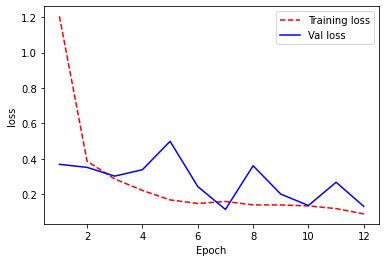

In [30]:
get_diagnostic_plot(model,'loss')

In [31]:
save_path = 'resnet50/'
tf.keras.models.save_model(model,save_path)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: resnet50/assets


In [32]:
f1_score_history = model.history.history['f1_score']
f1_scores = [np.mean(item) for item in  f1_score_history]
f1_score_val_hist = model.history.history['val_f1_score']
f1_scores_val = [np.mean(item) for item in  f1_score_val_hist]

Text(0, 0.5, 'F1 Score')

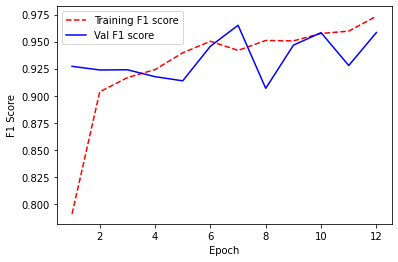

In [33]:
training_loss = f1_scores
test_loss = f1_scores_val

epoch_count = range(1, len(training_loss) + 1)

plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training F1 score', 'Val F1 score'])
plt.xlabel('Epoch')
plt.ylabel('F1 Score')

In [34]:
model.evaluate(test_generator)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


84/84 [==============================] - 176s 2s/step - loss: 0.0762 - accuracy: 0.9716 - f1_score: 0.9701


[0.0762077122926712,
 0.9715569019317627,
 array([0.99130434, 0.9389067 , 0.9802198 ], dtype=float32)]

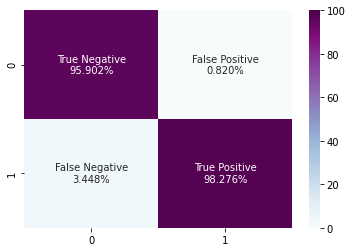

In [47]:
import seaborn as sns

f1_scores = np.array([0.99130434, 0.9389067 , 0.9802198 ])

tp = int(f1_scores[0] * TEST_POSITIVE_SIZE)
tn = int(((f1_scores[1] + f1_scores[2])/2) * TEST_NEGATIVE_SIZE)
fp = int((1-f1_scores[0]) * TEST_NEGATIVE_SIZE)
fn = int((((1-f1_scores[1]) + (1-f1_scores[2]))/2) * TEST_POSITIVE_SIZE)

cf_matrix = np.array([[tn / TEST_NEGATIVE_SIZE * 100, fp / TEST_NEGATIVE_SIZE * 100],
                      [fn / TEST_POSITIVE_SIZE * 100, tp / TEST_POSITIVE_SIZE * 100]
                    ])

group_names = ['True Negative','False Positive','False Negative','True Positive']
group_counts = [tn, fp, fn, tp]
percentages = [tn / TEST_NEGATIVE_SIZE, fp / TEST_NEGATIVE_SIZE, fn / TEST_POSITIVE_SIZE, tp / TEST_POSITIVE_SIZE]
group_percentages = ["{0:.3%}".format(value) for value in percentages]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, vmin = 0, vmax = 100, annot=labels, fmt='', cmap='BuPu')

In [48]:
sensitivity = tp / (tp + fn)
specifiticty = tn / (tn + fp)

print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specifiticty}')

Sensitivity: 0.9661016949152542
Specificity: 0.9915254237288136
